<a href="https://colab.research.google.com/github/COMP90054/2024-S2-tutorials/blob/main/problem_set_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP90054 AI Planning for Autonomy
### Problem Set 05 - Delete Relaxation


*Note- It is best to run this notebook on Colab(which runs an instance of linux), as the library requirements have been tested. As of now, we are aware of the issue that the `LAPKT`, Lighweight Automated Planning Toolkit, doesn't work on `macos`.*

*Note: The following exercises would require use of pen and paper to keep track of steps in the algorithms. The code blocks inputs in the notebook are primarliy to enable you to validate your working.*

## Key takeaways
- Understand delete relaxed heuristics
- Understand the relationship between $h^{add}$, $h^{add}$ and $h^+$

# Prepare the environment

In [ ]:
!pip install lapkt==0.1.1
!pip install func-timeout

from IPython.display import Latex, HTML
from func_timeout import func_timeout
from pandas import DataFrame, to_numeric, set_option
from numpy import inf
from lapkt.pddl.tarski import ground_generate_task as process_pddl
from lapkt.core.lib.wrapper import STRIPS_Interface, Fwd_Search_Problem, H_Add, H_Max
from functools import partial

import ipywidgets as widgets

# Four Action BlocksWorld
fluent_names = [
"clear(a)", "clear(b)", "clear(c)", "handempty()", "holding(a)", "holding(b)", "holding(c)", "on(a,a)", "on(a,b)", "on(a,c)", "on(b,a)", "on(b,b)", "on(b,c)", "on(c,a)", "on(c,b)", "on(c,c)", "ontable(a)", "ontable(b)", "ontable(c)"
]

# Four Action BlocksWorld PDDL
four_action_domain="""
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;;; 4 Op-blocks world
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

(define (domain BLOCKS)
  (:requirements :strips)
  (:predicates (on ?x ?y)
	       (ontable ?x)
	       (clear ?x)
	       (handempty)
	       (holding ?x)
	       )

  (:action pick-up
	     :parameters (?x)
	     :precondition (and (clear ?x) (ontable ?x) (handempty))
	     :effect
	     (and (not (ontable ?x))
		   (not (clear ?x))
		   (not (handempty))
		   (holding ?x)))

  (:action put-down
	     :parameters (?x)
	     :precondition (holding ?x)
	     :effect
	     (and (not (holding ?x))
		   (clear ?x)
		   (handempty)
		   (ontable ?x)))
  (:action stack
	     :parameters (?x ?y)
	     :precondition (and (holding ?x) (clear ?y))
	     :effect
	     (and (not (holding ?x))
		   (not (clear ?y))
		   (clear ?x)
		   (handempty)
		   (on ?x ?y)))
  (:action unstack
	     :parameters (?x ?y)
	     :precondition (and (on ?x ?y) (clear ?x) (handempty))
	     :effect
	     (and (holding ?x)
		   (clear ?y)
		   (not (clear ?x))
		   (not (handempty))
		   (not (on ?x ?y)))))

"""

four_action_problem="""
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;;; 4 Op-blocks world
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

(define (problem BLOCKS-example)
(:domain BLOCKS)
(:objects A B C)
(:INIT (CLEAR A) (CLEAR B) (ONTABLE B) (ONTABLE C) (ON A C) (HANDEMPTY))
(:goal (AND (ON A B) (ON B C)))
)
"""

# Create the PDDL domain file
with open("blocks_domain.pddl", 'w') as file:
  file.write(four_action_domain)

# Create the PDDL problem file
with open("blocks_problem.pddl", 'w') as file:
  file.write(four_action_problem)

four_action_blocks_problem = STRIPS_Interface("blocks_domain.pddl", "blocks_problem.pddl")

process_pddl("blocks_domain.pddl", "blocks_problem.pddl", four_action_blocks_problem)


# Two Action BlocksWorld PDDL

two_action_domain="""
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;;; 2 Op-blocks world
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

(define (domain BLOCKS)
  (:requirements :strips)
  (:predicates (on ?x ?y)
	       (ontable ?x)
	       (clear ?x)
	       )

  (:action move-to-block
	     :parameters (?x ?to)
	     :precondition (and (clear ?x) (ontable ?x) (clear ?to))
	     :effect
	     (and
		      (on ?x ?to)
	          (not (ontable ?x))
		      (not (clear ?to))

		 )
  )

 (:action move-to-table
	     :parameters (?x ?from)
	     :precondition (and (clear ?x) (on ?x ?from) )
	     :effect
	     (and (not (on ?x ?from))
		      (clear ?from)
		      (ontable ?x)
		 )
  )
)
"""

two_action_problem="""
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;;; 2 Op-blocks world
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

(define (problem BLOCKS-example)
(:domain BLOCKS)
(:objects A B C)
(:INIT (CLEAR A) (CLEAR B) (ONTABLE B) (ONTABLE C) (ON A C) )
(:goal (AND (ON A B) (ON B C)))
)
"""

# Create the PDDL domain file
with open("two_action_blocks_domain.pddl", 'w') as file:
  file.write(two_action_domain)

# Create the PDDL problem file
with open("two_action_blocks_problem.pddl", 'w') as file:
  file.write(two_action_problem)

two_action_blocks_problem = STRIPS_Interface("two_action_blocks_domain.pddl",
                                 "two_action_blocks_problem.pddl")

process_pddl("two_action_blocks_domain.pddl",
             "two_action_blocks_problem.pddl", two_action_blocks_problem)

def validate(problem, h_df, h_val, heuristic, b=None) -> bool :
    """
    Validates the final iteration of bellman variant and
    Parameters -
        problem : STRIPS instance
        h_add : manually computed h_add table
    """
    assert(heuristic in ["h_add", "h_max"])
    if(heuristic=="h_add"):
        print("VALIDATING H_ADD COMPUTATION\n")
        h = H_Add(problem)
    elif(heuristic=="h_max"):
        print("VALIDATING H_MAX COMPUTATION\n")
        h = H_Max(problem)
    else:
        raise ValueError("Incorrect heuristic type")

    value = h.compute_init_h()

    h_fluents = dict()
    h.fetch_hval_fluents(h_fluents)
    df = DataFrame([h_fluents]).astype(float)

    if h_val == to_numeric(value):
        print("1. Heuristic value for initial state is CORRECT :)\n")
    else:
        print("1. Heuristic value for initial state is INCORRECT :(\n")
    if h_df.loc[len(h_df)-1].equals(df.loc[len(df)-1]):
        print("2. Heuristic values in final Bellman Ford iteration CORRECT :)\n")
    else:
        print("2. Heuristic values in final Bellman Ford iteration is INCORRECT :(")
        print("HINT: Best supporter actions for each fluent")
        best_supporters = dict()
        h.fetch_best_supporters(best_supporters)
        print(best_supporters,"\n")

***Started - reading and parsing pddl file ...***
***Finished reading and parsing pddl file after 0.131 seconds wall-clock time, 0.117 seconds CPU time***

***Started - preprocessing tarski problem ...***
***Finished preprocessing tarski problem after 0.007 seconds wall-clock time, 0.003 seconds CPU time***

***Started - grounding ...***
Total number of reachable action params =  24
***Finished grounding after 0.158 seconds wall-clock time, 0.021 seconds CPU time***

***Started - instantiating ...***
***Finished instantiating after 0.004 seconds wall-clock time, 0.003 seconds CPU time***

***Started - reading and parsing pddl file ...***
***Finished reading and parsing pddl file after 0.073 seconds wall-clock time, 0.037 seconds CPU time***

***Started - preprocessing tarski problem ...***
***Finished preprocessing tarski problem after 0.007 seconds wall-clock time, 0.003 seconds CPU time***

***Started - grounding ...***
Total number of reachable action params =  18
***Finished ground

# Problem 1
Discuss in your group the heuristics you used in project 1. Are any of them related to the domain independent heuristics we have covered in class?

1. What is the (optimal) delete relaxation heuristic $h^+$ ? How would it be interpreted in pacman?
2. What is the relationship between $h^{max}$ , $h^+$ , and $h^{add}$? What about $h^∗$ ?

# Problem 2

In a blocks-world problem, the agent’s aim is to stack the blocks as in the below figure

Blocksworld Diagramatic Representation
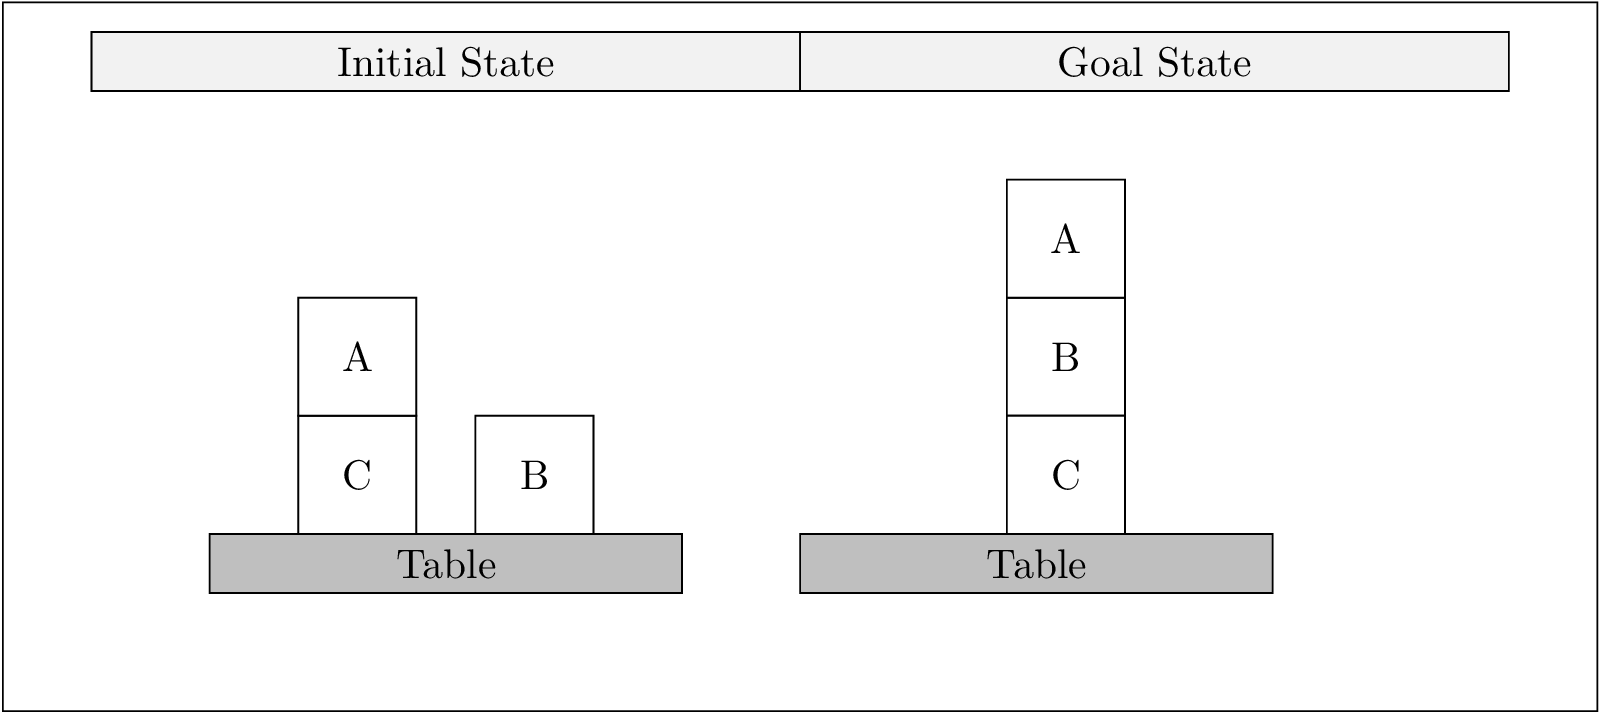

There are several important classes of domain-independent heuristics. Recall the delete relaxation based heuristics from Lectures.

We can compute $h^{add}$ and $h^{max}$ for the above Blocksworld problem.

### Task 1. Describe the init and goal set.

Instructions are within the triple-quotes.


In [ ]:
# Fluent Names
# ["clear(a)", "clear(b)", "clear(c)", "handempty()", "holding(a)", "holding(b)", "holding(c)", "on(a,a)", "on(a,b)", "on(a,c)", "on(b,a)", "on(b,b)", "on(b,c)", "on(c,a)", "on(c,b)", "on(c,c)", "ontable(a)", "ontable(b)", "ontable(c)"]

# INPUT REQUIRED
"""
Input the initial state
NOTE : Exact match with the fluent_names values is necessary
Example : init = {"clear(a)",  "clear(b)"}
"""
init = {}

# INPUT REQUIRED
"""
Input the goal set
NOTE : Exact match with the fluent_names values is necessary
Example : goal = {"clear(a)",  "clear(b)"}
"""
goal = {}

### Task 2. Compute $h^{add}(s_0)$ for the 4 operators blocks-world problem.

1. Input your working for $h^{add}$ computation using Bellman-Ford variant: below.

In [ ]:
# Column Headings (ordered)
# ["clear(a)", "clear(b)", "clear(c)", "handempty()", "holding(a)", "holding(b)", "holding(c)", "on(a,a)", "on(a,b)", "on(a,c)", "on(b,a)", "on(b,b)", "on(b,c)", "on(c,a)", "on(c,b)", "on(c,c)", "ontable(a)", "ontable(b)", "ontable(c)"]

h_add = DataFrame(columns = fluent_names)
# Initializing the bellman-ford variant to compute h_add
h_add.loc[len(h_add)] = [inf if f not in init else '0' for f in fluent_names]

# INPUT REQUIRED
"""
Input the values from your working for Iteration 1
"""
h_add.loc[len(h_add)] = ['', '', '', '' , '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

# INPUT REQUIRED
"""
Input the values from your working for Iteration 2
"""
h_add.loc[len(h_add)] = ['', '', '', '' , '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

# INPUT REQUIRED
"""
Continue for necessary number of iterations...
"""
h_add.loc[len(h_add)] = ['', '', '', '' , '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

# Displays the h_add table
display(h_add)

,clear(a),clear(b),clear(c),handempty(),holding(a),holding(b),holding(c),"on(a,a)","on(a,b)","on(a,c)","on(b,a)","on(b,b)","on(b,c)","on(c,a)","on(c,b)","on(c,c)",ontable(a),ontable(b),ontable(c)
0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,,,,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,,,,


2. Based on the above table what is the value of $h_{add}(s_0)$?

In [ ]:
h_add_init = 0 # replace the value

##### Validate your answer

In [ ]:
# Renders the button to validate solution
btn_h_add = widgets.Button(description='Click to validate', icon='check')
display(HTML('''<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"> '''))
btn_h_add.on_click(partial(validate, four_action_blocks_problem, h_add, h_add_init, "h_add"))
btn_h_add

Button(description='Click to validate', icon='check', style=ButtonStyle())

### Task 3. Compute $h^{max}(s_0)$ for the 4 operators blocks-world problem.

1. Input your working for $h^{max}$ computation using Bellman-Ford variant: below. Instructions are within the triple-quotes.


In [ ]:
# Column Headings (ordered)
# ["clear(a)", "clear(b)", "clear(c)", "handempty()", "holding(a)", "holding(b)", "holding(c)", "on(a,a)", "on(a,b)", "on(a,c)", "on(b,a)", "on(b,b)", "on(b,c)", "on(c,a)", "on(c,b)", "on(c,c)", "ontable(a)", "ontable(b)", "ontable(c)"]

h_max = DataFrame(columns = fluent_names)
# Initializing the bellman-ford variant to compute h_max
h_max.loc[len(h_max)] = [inf if f not in init else '0' for f in fluent_names]

# INPUT REQUIRED
"""
Input the values from your working for Iteration 1
"""
h_max.loc[len(h_max)] = ['', '', '', '' , '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

# INPUT REQUIRED
"""
Input the values from your working for Iteration 2
"""
h_max.loc[len(h_max)] = ['', '', '', '' , '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

# INPUT REQUIRED
"""
Continue for necessary number of iterations...
"""
h_max.loc[len(h_max)] = ['', '', '', '' , '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


# Displays the h_max table
display(h_max)

,clear(a),clear(b),clear(c),handempty(),holding(a),holding(b),holding(c),"on(a,a)","on(a,b)","on(a,c)","on(b,a)","on(b,b)","on(b,c)","on(c,a)","on(c,b)","on(c,c)",ontable(a),ontable(b),ontable(c)
0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,,,,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,,,,


2. Based on the above table what is the value of $h_{max}(s_0)$?

In [ ]:
h_max_init = 0 # replace the value

##### Validate your answer

In [ ]:
# Renders the button to validate solution
btn_h_max = widgets.Button(description='Click to validate', icon='check')
display(HTML('''<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"> '''))
btn_h_max.on_click(partial(validate, four_action_blocks_problem, h_max, h_max_init, "h_max"))
btn_h_max

Button(description='Click to validate', icon='check', style=ButtonStyle())

# Help

## View the grounded representation of the blocksworld problem in propositional logic.

#### Four action model of Blocksworld

In [ ]:
#### Here we show the problem representation after parsing and grounding the
#### PDDL into propositional logic

print("###### DOMAIN REPRESENTATION in PROPOSITIONAL LOGIC ######\n")

print("Size of operator set:", four_action_blocks_problem.num_actions())
print("Size of set of fluents:", four_action_blocks_problem.num_atoms())



four_action_blocks_problem.print_actions()
# Print action list
with open("actions.list", 'r') as file:
  print(file.read())

four_action_blocks_problem.print_fluents()
# Print fluent list
with open("fluents.list", 'r') as file:
  print(file.read())

###### DOMAIN REPRESENTATION in PROPOSITIONAL LOGIC ######

Size of operator set: 24
Size of set of fluents: 19
Actions
Action (pick-up a)
	Pre(a) = {clear(a), ontable(a), handempty()}
	Add(a) = {holding(a)}
	Del(a) = {ontable(a), clear(a), handempty()}
	eDel(a) = {ontable(a), clear(a), handempty()}
	Conditional Effects:
Cost = 1
Action (pick-up b)
	Pre(a) = {clear(b), ontable(b), handempty()}
	Add(a) = {holding(b)}
	Del(a) = {ontable(b), clear(b), handempty()}
	eDel(a) = {ontable(b), clear(b), handempty()}
	Conditional Effects:
Cost = 1
Action (pick-up c)
	Pre(a) = {clear(c), ontable(c), handempty()}
	Add(a) = {holding(c)}
	Del(a) = {ontable(c), clear(c), handempty()}
	eDel(a) = {ontable(c), clear(c), handempty()}
	Conditional Effects:
Cost = 1
Action (put-down a)
	Pre(a) = {holding(a)}
	Add(a) = {clear(a), handempty(), ontable(a)}
	Del(a) = {holding(a)}
	eDel(a) = {holding(a)}
	Conditional Effects:
Cost = 1
Action (put-down b)
	Pre(a) = {holding(b)}
	Add(a) = {clear(b), handempty(), 

#### Two action model of Blocksworld


In [ ]:
#### Here we show the problem representation after parsing and grounding the
#### PDDL into propositional logic

print("###### DOMAIN REPRESENTATION in PROPOSITIONAL LOGIC ######\n")

print("Size of operator set:", two_action_blocks_problem.num_actions())
print("Size of set of fluents:", two_action_blocks_problem.num_atoms(), "\n")

two_action_blocks_problem.print_actions()
# Print action list
print("# ---- #\nAction Set:\n")
with open("actions.list", 'r') as file:
  print(file.read())

two_action_blocks_problem.print_fluents()
# Print fluent list
print("# ---- #\nFluent Set:\n")
with open("fluents.list", 'r') as file:
  print(file.read())

###### DOMAIN REPRESENTATION in PROPOSITIONAL LOGIC ######

Size of operator set: 18
Size of set of fluents: 15 

# ---- #
Action Set:

Actions
Action (move-to-block a a)
	Pre(a) = {clear(a), ontable(a), clear(a)}
	Add(a) = {on(a,a)}
	Del(a) = {ontable(a), clear(a)}
	eDel(a) = {ontable(a), clear(a)}
	Conditional Effects:
Cost = 1
Action (move-to-block a b)
	Pre(a) = {clear(a), ontable(a), clear(b)}
	Add(a) = {on(a,b)}
	Del(a) = {ontable(a), clear(b)}
	eDel(a) = {ontable(a), clear(b)}
	Conditional Effects:
Cost = 1
Action (move-to-block a c)
	Pre(a) = {clear(a), ontable(a), clear(c)}
	Add(a) = {on(a,c)}
	Del(a) = {ontable(a), clear(c)}
	eDel(a) = {ontable(a), clear(c)}
	Conditional Effects:
Cost = 1
Action (move-to-block b a)
	Pre(a) = {clear(b), ontable(b), clear(a)}
	Add(a) = {on(b,a)}
	Del(a) = {ontable(b), clear(a)}
	eDel(a) = {ontable(b), clear(a)}
	Conditional Effects:
Cost = 1
Action (move-to-block b b)
	Pre(a) = {clear(b), ontable(b), clear(b)}
	Add(a) = {on(b,b)}
	Del(a) = {ont

## View set of supporting actions for each fluent

In [ ]:
#HINT

print("Set of supporters for each fluent:")
supporting_actions = dict()
H_Add(four_action_blocks_problem).fetch_supporting_actions(supporting_actions)

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

for k in supporting_actions.keys():
  print(k,":")
  for v in supporting_actions[k]:
    print("\t",v)

Set of supporters for each fluent:


<IPython.core.display.Javascript object>

clear(a) :
	 (put-down a)
	 (stack a a)
	 (stack a b)
	 (stack a c)
	 (unstack a a)
	 (unstack b a)
	 (unstack c a)
clear(b) :
	 (put-down b)
	 (stack b a)
	 (stack b b)
	 (stack b c)
	 (unstack a b)
	 (unstack b b)
	 (unstack c b)
clear(c) :
	 (put-down c)
	 (stack c a)
	 (stack c b)
	 (stack c c)
	 (unstack a c)
	 (unstack b c)
	 (unstack c c)
handempty() :
	 (put-down a)
	 (put-down b)
	 (put-down c)
	 (stack a a)
	 (stack a b)
	 (stack a c)
	 (stack b a)
	 (stack b b)
	 (stack b c)
	 (stack c a)
	 (stack c b)
	 (stack c c)
holding(a) :
	 (pick-up a)
	 (unstack a a)
	 (unstack a b)
	 (unstack a c)
holding(b) :
	 (pick-up b)
	 (unstack b a)
	 (unstack b b)
	 (unstack b c)
holding(c) :
	 (pick-up c)
	 (unstack c a)
	 (unstack c b)
	 (unstack c c)
on(a,a) :
	 (stack a a)
on(a,b) :
	 (stack a b)
on(a,c) :
	 (stack a c)
on(b,a) :
	 (stack b a)
on(b,b) :
	 (stack b b)
on(b,c) :
	 (stack b c)
on(c,a) :
	 (stack c a)
on(c,b) :
	 (stack c b)
on(c,c) :
	 (stack c c)
ontable(a) :
	 (put-down a